In [1]:
!nvidia-smi

Wed Nov 29 20:24:56 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   34C    P8                6W /  N/A|     57MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
import cv2
import os
import numpy as np
import seaborn as sns
data_dir = "Data"

labels = ['cats','dogs']
img_size = 32
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [8]:
train = get_data(r"C:\Users\Chlangdiam Sumer\OneDrive\Desktop\M. Tech\M. Tech Thesis\4th Sem\Data\train")
val = get_data(r"C:\Users\Chlangdiam Sumer\OneDrive\Desktop\M. Tech\M. Tech Thesis\4th Sem\Data\test")
l = []
for i in train:
    if(i[1] == 0):
        l.append("cats")
    else:
        l.append("dogs")
# sns.set_style('darkgrid')
# sns.countplot(l)

C:\Users\Chlangdiam Sumer\AppData\Local\Temp\ipykernel_10196\661556943.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [9]:
num_classes = len(labels)
print(num_classes)

2


In [10]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [11]:
# Building the Model Architecture
model = Sequential()
# Select 6 feature convolution kernels with a size of 5 * 5 (without offset), and get 66 feature maps. The size of each feature map is 32−5 + 1 = 2832−5 + 1 = 28.
# That is, the number of neurons has been reduced from 10241024 to 28 ∗ 28 = 784 28 ∗ 28 = 784.
# Parameters between input layer and C1 layer: 6 ∗ (5 ∗ 5 + 1)
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(img_size,img_size,3)))
# The input of this layer is the output of the first layer, which is a 28 * 28 * 6 node matrix.
# The size of the filter used in this layer is 2 * 2, and the step length and width are both 2, so the output matrix size of this layer is 14 * 14 * 6.
model.add(MaxPooling2D(pool_size=(2, 2)))
# The input matrix size of this layer is 14 * 14 * 6, the filter size used is 5 * 5, and the depth is 16. This layer does not use all 0 padding, and the step size is 1.
# The output matrix size of this layer is 10 * 10 * 16. This layer has 5 * 5 * 6 * 16 + 16 = 2416 parameters
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
# The input matrix size of this layer is 10 * 10 * 16. The size of the filter used in this layer is 2 * 2, and the length and width steps are both 2, so the output matrix size of this layer is 5 * 5 * 16.
model.add(MaxPooling2D(pool_size=(2, 2)))
# The input matrix size of this layer is 5 * 5 * 16. This layer is called a convolution layer in the LeNet-5 paper, but because the size of the filter is 5 * 5, #
# So it is not different from the fully connected layer. If the nodes in the 5 * 5 * 16 matrix are pulled into a vector, then this layer is the same as the fully connected layer.
# The number of output nodes in this layer is 120, with a total of 5 * 5 * 16 * 120 + 120 = 48120 parameters.
model.add(Flatten())
model.add(Dense(4000,activation="relu"))
model.add(Dense(1000,activation="relu"))
model.add(Dense(100,activation="relu"))
model.add(Dense(num_classes, activation="sigmoid"))

In [12]:
import tensorflow as tf
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.000001),
    metrics=['accuracy']    
)
model.summary()


train_ds=tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_ds=tf.data.Dataset.from_tensor_slices((x_val,y_val))


def process_image(image,label):
    image=tf.image.per_image_standardization(image)
    image=tf.image.resize(image,(img_size,img_size))
    
    return image,label



train_ds_size=tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size=tf.data.experimental.cardinality(test_ds).numpy()
print('Train size:',train_ds_size)
print('Test size:',test_ds_size)



train_ds=(train_ds
          .map(process_image)
          .shuffle(buffer_size=train_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )
test_ds=(test_ds
          .map(process_image)
          .shuffle(buffer_size=test_ds_size)
          .batch(batch_size=32,drop_remainder=True)
         )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 4000)              1

C:\Users\Chlangdiam Sumer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Train size: 8005
Test size: 2023


In [13]:
from keras.optimizers import Adam
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

C:\Users\Chlangdiam Sumer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(x_train,y_train,epochs = 50 , validation_data = (x_val, y_val))

Epoch 1/50


C:\Users\Chlangdiam Sumer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


251/251 [==============================] - 9s 7ms/step - loss: 0.6896 - accuracy: 0.5385 - val_loss: 0.6871 - val_accuracy: 0.5571
Epoch 2/50
251/251 [==============================] - 1s 6ms/step - loss: 0.6864 - accuracy: 0.5620 - val_loss: 0.6839 - val_accuracy: 0.5764
Epoch 3/50
251/251 [==============================] - 1s 6ms/step - loss: 0.6835 - accuracy: 0.5739 - val_loss: 0.6818 - val_accuracy: 0.5675
Epoch 4/50
251/251 [==============================] - 1s 6ms/step - loss: 0.6810 - accuracy: 0.5853 - val_loss: 0.6793 - val_accuracy: 0.5996
Epoch 5/50
251/251 [==============================] - 1s 6ms/step - loss: 0.6790 - accuracy: 0.5948 - val_loss: 0.6768 - val_accuracy: 0.6065
Epoch 6/50
251/251 [==============================] - 1s 6ms/step - loss: 0.6767 - accuracy: 0.5996 - val_loss: 0.6758 - val_accuracy: 0.5833
Epoch 7/50
251/251 [==============================] - 1s 6ms/step - loss: 0.6745 - accuracy: 0.6031 - val_loss: 0.6726 - val_accuracy: 0.6179
Epoch 8/50
251/25

In [ ]:
import matplotlib.pyplot as plt
# plot the accuracy
plt.plot(history.history['accuracy'], label='training acc')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')
 
# plot the loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training and Validation Loss')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

In [ ]:
model.evaluate(x_val, y_val)

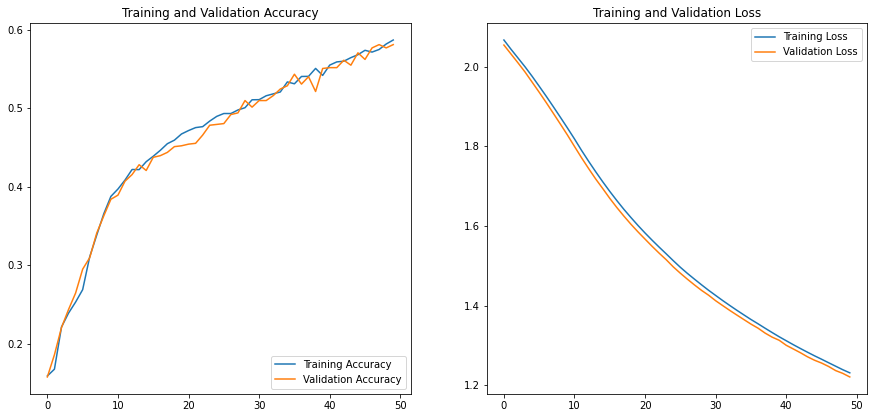

30/30 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

         2S1       0.50      0.27      0.35       118
      BRDM_2       0.55      0.74      0.63       142
      BTR_60       0.67      0.86      0.75       136
          D7       0.00      0.00      0.00        58
       SLICY       0.86      0.96      0.91       127
         T62       0.47      0.56      0.51       116
      ZIL131       0.55      0.19      0.28       115
    ZSU_23_4       0.45      0.65      0.53       141

    accuracy                           0.58       953
   macro avg       0.51      0.53      0.50       953
weighted avg       0.54      0.58      0.54       953

[[ 32  35  30   0   1  12   3   5]
 [ 10 105  11   0   3   3   3   7]
 [  3   7 117   0   0   1   1   7]
 [  0   2   0   0   0  15  10  31]
 [  0   0   1   0 122   0   0   4]
 [  2   7   5   0   0  65   0  37]
 [  7  25   9   0   2  29  22  21]
 [ 10   9   2   0  14  14   1  91]]


C:\Users\Chlangdiam Sumer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chlangdiam Sumer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chlangdiam Sumer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

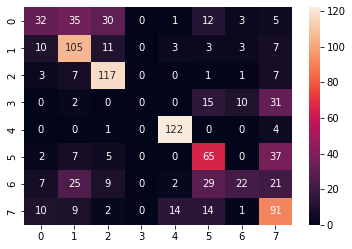

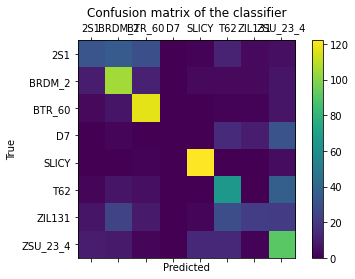

              precision    recall  f1-score   support

         2S1       0.50      0.27      0.35       118
      BRDM_2       0.55      0.74      0.63       142
      BTR_60       0.67      0.86      0.75       136
          D7       0.00      0.00      0.00        58
       SLICY       0.86      0.96      0.91       127
         T62       0.47      0.56      0.51       116
      ZIL131       0.55      0.19      0.28       115
    ZSU_23_4       0.45      0.65      0.53       141

    accuracy                           0.58       953
   macro avg       0.51      0.53      0.50       953
weighted avg       0.54      0.58      0.54       953



C:\Users\Chlangdiam Sumer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chlangdiam Sumer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chlangdiam Sumer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In [26]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

from sklearn.metrics import classification_report
import seaborn as sns
predictions = np.argmax(model.predict(x_val), axis=-1)
from sklearn.metrics import confusion_matrix
print(classification_report(y_valA, predictions, target_names = ['2S1','BRDM_2','BTR_60','D7','SLICY','T62','ZIL131','ZSU_23_4']))

cm = confusion_matrix(y_valA, predictions) 
sns.heatmap(cm, annot= True, fmt='d')

print(cm) 

fig = plt.figure() 

ax = fig.add_subplot(111) 

cax = ax.matshow(cm) 

plt.title('Confusion matrix of the classifier') 

fig.colorbar(cax) 

ax.set_xticklabels([''] + labels) 

ax.set_yticklabels([''] + labels) 

plt.xlabel('Predicted') 

plt.ylabel('True') 

plt.show()





print(classification_report(y_valA, predictions, target_names = ['2S1','BRDM_2','BTR_60','D7','SLICY','T62','ZIL131','ZSU_23_4']))